In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

In [2]:
# Read index
df = pd.read_csv('nina34.anom.data', sep=r'\s+', header=None)
df.columns = ['years'] + [f'{month}' for month in range(1, 13)]
df

,years,1,2,3,4,5,6,7,8,9,10,11,12
0,1948,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
1,1949,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
2,1950,-1.99,-1.69,-1.42,-1.54,-1.75,-1.27,-1.01,-0.97,-0.98,-1.03,-1.23,-1.31
3,1951,-1.30,-1.04,-0.38,-0.23,-0.01,0.00,0.30,0.17,0.51,0.49,0.55,0.31
4,1952,0.13,-0.01,-0.11,-0.02,-0.14,-0.54,-0.76,-0.56,-0.36,-0.46,-0.78,-0.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,2020,0.60,0.37,0.48,0.36,-0.27,-0.34,-0.30,-0.59,-0.83,-1.26,-1.42,-1.15
73,2021,-1.00,-1.00,-0.80,-0.72,-0.46,-0.28,-0.39,-0.53,-0.55,-0.94,-0.94,-1.06
74,2022,-0.94,-0.89,-0.97,-1.11,-1.11,-0.75,-0.69,-0.97,-1.07,-0.99,-0.90,-0.85
75,2023,-0.72,-0.46,-0.11,0.14,0.46,0.84,1.02,1.35,1.60,1.72,2.02,2.03


In [3]:
years = np.arange(1980,2015)
nyr = len(years)
nino34_Jan = df['1'][(df['years'] >= 1980) & (df['years'] <= 2014)]

In [4]:
id_el = np.where(nino34_Jan>=1)
id_la = np.where(nino34_Jan<=-1)
id_ne = np.where((nino34_Jan>-1) &(nino34_Jan<1))

In [5]:
year_el = years[id_el]
year_la = years[id_la]
year_ne = years[id_ne]
counts = [len(year_el),len(year_la),len(year_ne)]

In [6]:
print(year_el)
print(year_la)
print(year_ne)

[1983 1987 1992 1995 1998 2010]
[1985 1989 1999 2000 2008 2011]
[1980 1981 1982 1984 1986 1988 1990 1991 1993 1994 1996 1997 2001 2002
 2003 2004 2005 2006 2007 2009 2012 2013 2014]


In [7]:
# velocity potential data
dname = 'model'
if (dname == 'model'):
    idir = '/scratch/jjung45/mjo/vp200/'
    fname = idir + 'vp200_200801.nc' #float prate(ens,time,lat,lon); mm/day

#ERA5
if (dname == 'era'): 
    idir = '~/_scratch/ERA5/daily/vp200/'
    fname = idir + 'vp200_200801.nc'

In [8]:
ds = xr.open_dataset(fname)
ds

<xarray.Dataset> Size: 24MB
Dimensions:  (time: 91, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 728B 2008-01-01 2008-01-02 ... 2008-03-31
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Data variables:
    vp200    (time, lat, lon) float32 24MB ...

In [9]:
lat = ds['lat'].sel(lat=slice(-30,30))
lon = ds['lon']
nlat = len(lat)
nlon = len(lon)

time = ds['time']
ntime = len(time)

In [10]:
vp_array = np.empty((nyr,ntime,nlat,nlon),dtype=np.float32)

In [11]:
for n, year in enumerate(years):
    vp_path = idir+f'vp200_{year}01.nc'
    ds_vp = xr.open_dataset(vp_path)
    vp_array[n,:,:,:] = ds_vp['vp200'].sel(lat=slice(-30, 30))

In [12]:
vp_array = xr.DataArray(vp_array,dims=['years','time','lat','lon'],
                       coords={'years': years,
                              'time': time,
                              'lat': lat,
                              'lon': lon}, name = 'vp')

In [13]:
vp_clim = vp_array.mean('years')

In [14]:
vp_ano = vp_array - vp_clim

In [15]:
ano_el = vp_ano.sel(years=year_el)
ano_la = vp_ano.sel(years=year_la)
ano_ne = vp_ano.sel(years=year_ne)

In [16]:
ano_el_yr = ano_el.mean(dim="time").mean(dim="years")
ano_la_yr = ano_la.mean(dim="time").mean(dim="years")
ano_ne_yr = ano_ne.mean(dim="time").mean(dim="years")
comp_ano = [ano_el_yr, ano_la_yr, ano_ne_yr]

In [17]:
diff_el = ano_el_yr - ano_ne_yr
diff_la = ano_la_yr - ano_ne_yr
diff = [diff_el,diff_la]

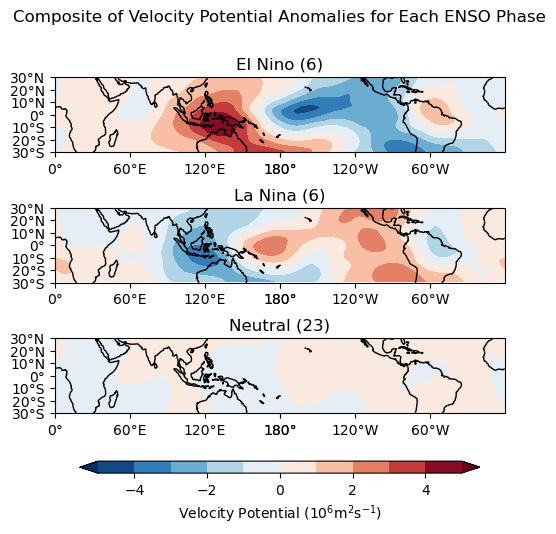

In [18]:
labels=['El Nino','La Nina', 'Neutral']
clevs = np.arange(-5,6,1)

# Define the figure and each axis for the 1 rows and 3 columns
fig, axs = plt.subplots(nrows=3,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)},
                        figsize=(5,8))

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array (just 3 rows)
axs = axs.flatten()

#Loop over all of the cases and plot
for i,enso in enumerate(comp_ano):

        # Select the case
        data = comp_ano[i]*1e-06

        # Add the cyclic point
        data,lons = add_cyclic_point(data,coord=comp_ano[i]['lon'])

        # Contour plot
        cs=axs[i].contourf(lons,comp_ano[i]['lat'],data,clevs,
                          transform = ccrs.PlateCarree(),
                          cmap=plt.cm.RdBu_r,extend='both')

        # Longitude labels
        axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        axs[i].set_yticks(np.arange(-30,31,10), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        
        # Title each subplot with the name of the season
        axs[i].set_title(labels[i] + ' ('+str(counts[i])+')')

        # Draw the coastines for each subplot
        axs[i].coastlines()
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=1.12, left=0.05, right=0.95,
                    wspace=0.1, hspace=-0.7)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.1, 0.4, 0.8, 0.015])

# Draw the colorbar
cbar = fig.colorbar(cs,cax=cbar_ax,orientation='horizontal'
                    ,label="Velocity Potential ($10^6$m$^2$s$^{-1}$)")

# Add a big title at the top
plt.suptitle('Composite of Velocity Potential Anomalies for Each ENSO Phase') ;

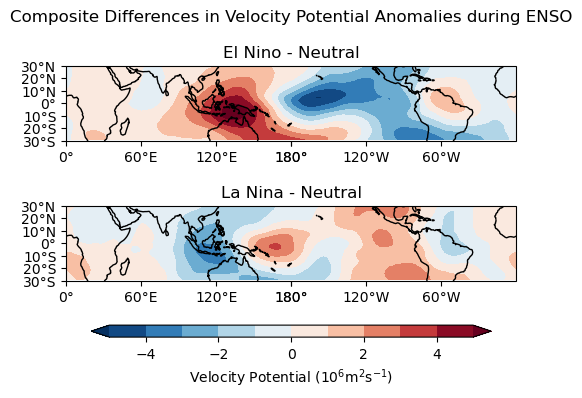

In [19]:
labels=['El Nino - Neutral','La Nina - Neutral']
clevs = np.arange(-5,6,1)

# Define the figure and each axis for the 1 rows and 2 columns
fig, axs = plt.subplots(nrows=2,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)},
                        figsize=(5,8))

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array (just 3 rows)
axs = axs.flatten()

#Loop over all of the cases and plot
for i,enso in enumerate(diff):

        # Select the case
        data = diff[i]*1e-06

        # Add the cyclic point
        data,lons = add_cyclic_point(data,coord=diff[i]['lon'])

        # Contour plot
        cs=axs[i].contourf(lons,diff[i]['lat'],data,clevs,
                          transform = ccrs.PlateCarree(),
                          cmap=plt.cm.RdBu_r,extend='both')

        # Longitude labels
        axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        axs[i].set_yticks(np.arange(-30,31,10), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        # Title each subplot with the name of the season
        axs[i].set_title(labels[i])

        # Draw the coastines for each subplot
        axs[i].coastlines()
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=1.3, left=0.05, right=0.95,
                    wspace=0.1, hspace=-0.8)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.1, 0.57, 0.8, 0.015])

# Draw the colorbar
cbar = fig.colorbar(cs,cax=cbar_ax,orientation='horizontal'
                    ,label="Velocity Potential ($10^6$m$^2$s$^{-1}$)")

# Add a big title at the top
plt.suptitle('Composite Differences in Velocity Potential Anomalies during ENSO') ;

In [20]:
from scipy.stats import ttest_ind

In [21]:
test1=vp_ano.mean(dim="time")
test2=ano_el.mean(dim="time")
test3 =ano_la.mean(dim="time")

In [22]:
tstat1,pval1 = ttest_ind(test2, 
                test1, 
                equal_var = False)
tstat2,pval2 = ttest_ind(test3, 
                test1, 
                equal_var = False)

In [23]:
# plt.contourf(pval,[0,0.05,1],cmap='RdPu_r') 
# plt.colorbar(orientation='horizontal') ;

In [24]:
p = 0.05 
mask_diff1 = diff[0].where(pval1 <= p)
mask_diff2 = diff[1].where(pval2 <= p)
mask_diff = [mask_diff1,mask_diff2]

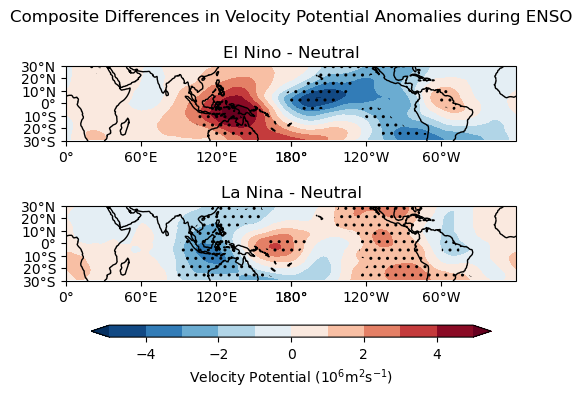

In [25]:
labels=['El Nino - Neutral','La Nina - Neutral']
clevs = np.arange(-5,6,1)
hatch_levs=[0]

# Define the figure and each axis for the 1 rows and 3 columns
fig, axs = plt.subplots(nrows=2,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)},
                        figsize=(5,8))

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array (just 3 rows)
axs = axs.flatten()

#Loop over all of the cases and plot
for i,enso in enumerate(diff):

        # Select the case
        data = diff[i]*1e-06

        # Add the cyclic point
        data,lons = add_cyclic_point(data,coord=diff[i]['lon'])
        mask_data,lons=add_cyclic_point(mask_diff[i],coord=diff[i]['lon'])

        # Contour plot
        cs=axs[i].contourf(lons,diff[i]['lat'],data,clevs,
                          transform = ccrs.PlateCarree(),
                          cmap=plt.cm.RdBu_r,extend='both')
        ss=axs[i].contourf(lons,diff[i]['lat'],mask_data,[0,1],
                transform = ccrs.PlateCarree(),colors=['None'],
                hatches=['..',''],extend='both',alpha=0.0)

        # Longitude labels
        axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        axs[i].set_yticks(np.arange(-30,31,10), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        # Title each subplot with the name of the season
        axs[i].set_title(labels[i])

        # Draw the coastines for each subplot
        axs[i].coastlines()
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=1.3, left=0.05, right=0.95,
                    wspace=0.1, hspace=-0.8)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.1, 0.57, 0.8, 0.015])

# Draw the colorbar
cbar = fig.colorbar(cs,cax=cbar_ax,orientation='horizontal'
                    ,label="Velocity Potential ($10^6$m$^2$s$^{-1}$)")

# Add a big title at the top
plt.suptitle('Composite Differences in Velocity Potential Anomalies during ENSO') ;